In [1]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

In [2]:
pip install pandas

In [3]:
# Load dataset
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('Price', axis=1)
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor

# Use XGBoost for RFE to stay consistent
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# RFE
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


✅ Top 10 Selected Features by RFE:
 - 1
 - 5
 - 6
 - 8
 - 17
 - 37
 - 76
 - 81
 - 169
 - 173

❌ Features Ignored by RFE:
 - 0
 - 2
 - 3
 - 4
 - 7
 - 9
 - 10
 - 11
 - 12
 - 13
 - 14
 - 15
 - 16
 - 18
 - 19
 - 20
 - 21
 - 22
 - 23
 - 24
 - 25
 - 26
 - 27
 - 28
 - 29
 - 30
 - 31
 - 32
 - 33
 - 34
 - 35
 - 36
 - 38
 - 39
 - 40
 - 41
 - 42
 - 43
 - 44
 - 45
 - 46
 - 47
 - 48
 - 49
 - 50
 - 51
 - 52
 - 53
 - 54
 - 55
 - 56
 - 57
 - 58
 - 59
 - 60
 - 61
 - 62
 - 63
 - 64
 - 65
 - 66
 - 67
 - 68
 - 69
 - 70
 - 71
 - 72
 - 73
 - 74
 - 75
 - 77
 - 78
 - 79
 - 80
 - 82
 - 83
 - 84
 - 85
 - 86
 - 87
 - 88
 - 89
 - 90
 - 91
 - 92
 - 93
 - 94
 - 95
 - 96
 - 97
 - 98
 - 99
 - 100
 - 101
 - 102
 - 103
 - 104
 - 105
 - 106
 - 107
 - 108
 - 109
 - 110
 - 111
 - 112
 - 113
 - 114
 - 115
 - 116
 - 117
 - 118
 - 119
 - 120
 - 121
 - 122
 - 123
 - 124
 - 125
 - 126
 - 127
 - 128
 - 129
 - 130
 - 131
 - 132
 - 133
 - 134
 - 135
 - 136
 - 137
 - 138
 - 139
 - 140
 - 141
 - 142
 - 143
 - 144
 - 145
 - 146
 - 1

In [5]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price Prediction Experiment")


2025/10/21 16:57:10 INFO mlflow.tracking.fluent: Experiment with name 'House Price Prediction Experiment' does not exist. Creating a new experiment.


In [6]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror')
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    }
}


In [7]:
def evaluate_model_with_gridsearch(name, model, grid, X_train, y_train, X_test, y_test):
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://localhost:5555


In [8]:
results = {}

with mlflow.start_run(run_name="model_comparison") if mlflow_tracking_uri else nullcontext():
    for name, model in models.items():
        logger.info(f"Training {name}...")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_tracking_uri else nullcontext():
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], X_train, y_train, X_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


INFO:root:Training LinearRegression...
2025/10/21 16:57:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 16:58:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression R2: 0.5191, RMSE: 2103006124.41
🏃 View run LinearRegression at: http://localhost:5555/#/experiments/1/runs/b681f0f0e51f44539d0fa5fbdf2ce623
🧪 View experiment at: http://localhost:5555/#/experiments/1


INFO:root:Training RandomForest...
2025/10/21 16:59:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 16:59:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest R2: 0.5066, RMSE: 2130123071.21
🏃 View run RandomForest at: http://localhost:5555/#/experiments/1/runs/830ce8e90a6d4460942d2ee7cb616ce9
🧪 View experiment at: http://localhost:5555/#/experiments/1


INFO:root:Training GradientBoosting...
2025/10/21 16:59:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 17:00:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoosting R2: 0.5312, RMSE: 2076252017.81
🏃 View run GradientBoosting at: http://localhost:5555/#/experiments/1/runs/8fe3264609e24405bafdc77d6a3cb771
🧪 View experiment at: http://localhost:5555/#/experiments/1


INFO:root:Training XGBoost...
2025/10/21 17:00:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 17:00:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost R2: 0.5026, RMSE: 2138633989.53
🏃 View run XGBoost at: http://localhost:5555/#/experiments/1/runs/ffe3045e0acd4d01b6e84c5096a70a98
🧪 View experiment at: http://localhost:5555/#/experiments/1
🏃 View run model_comparison at: http://localhost:5555/#/experiments/1/runs/631b53839a8c4390b10916f739d82ef1
🧪 View experiment at: http://localhost:5555/#/experiments/1


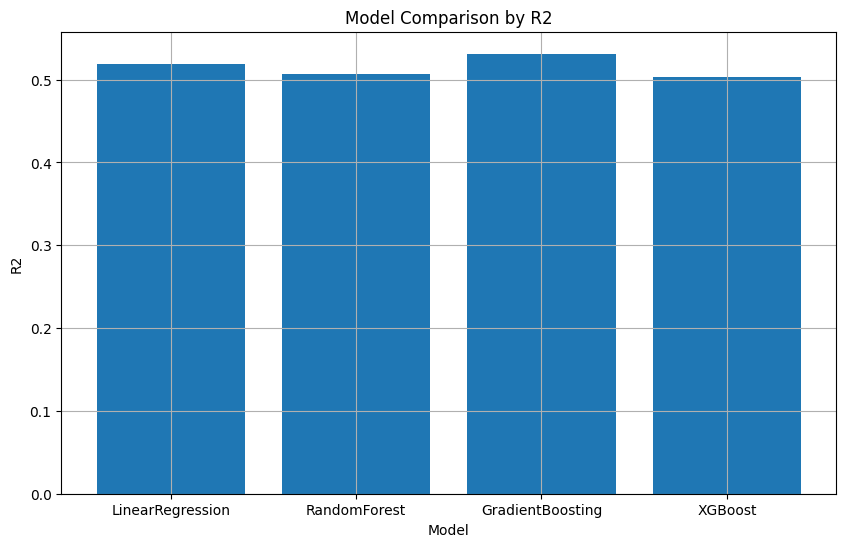

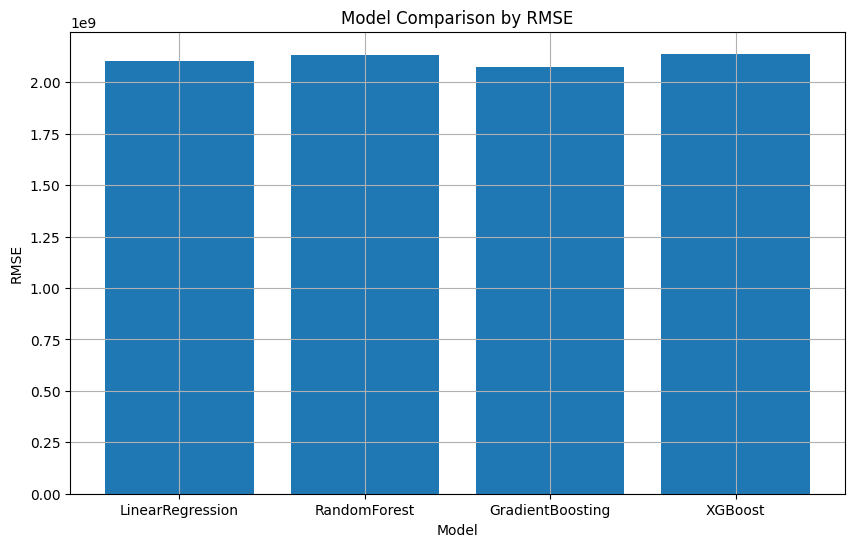

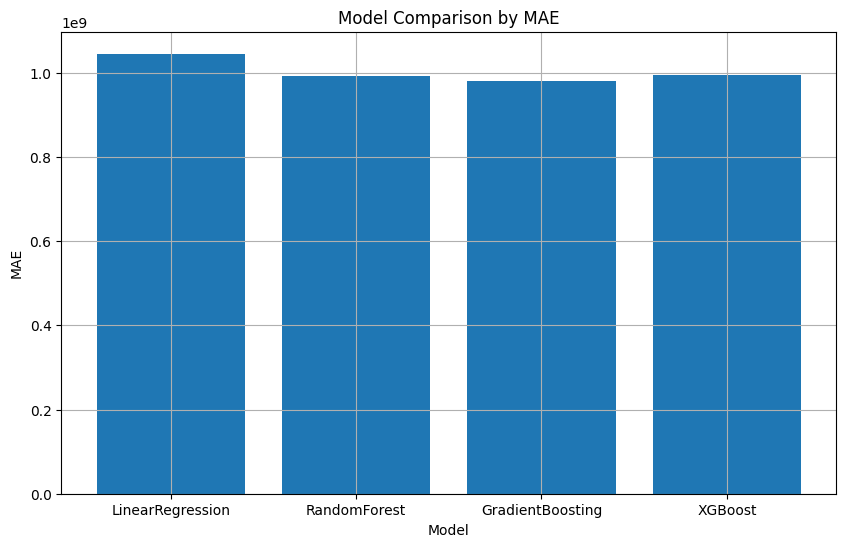

In [9]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()

# Example usage:
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')



In [10]:
import yaml

# Save model config with selected features 
# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")

model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")


🏆 Best Model: GradientBoosting
   R² Score: 0.5312
   MAE: 980026821.17
   RMSE: 2076252017.81
Saved model config to ../configs/model_config.yaml


In [11]:
best_name = max(results, key=lambda k: results[k]["r2"])
best_info = results[best_name]
best_model = best_info["model"]


In [12]:
import mlflow, mlflow.sklearn, joblib

mlflow.set_tracking_uri("http://localhost:5555")
mlflow.set_experiment("House Price Prediction Experiment")

with mlflow.start_run(run_name=f"{best_name}_best"):
    # params (aman di-try kalau ada estimator yg tidak expose semua param)
    try:
        mlflow.log_params(best_model.get_params())
    except Exception:
        pass

    # metrics dari hasil seleksi
    mlflow.log_metrics({
        "r2":   float(best_info["r2"]),
        "rmse": float(best_info["rmse"]),
        "mae":  float(best_info["mae"]),
    })

    # log sebagai MLflow Model
    mlflow.sklearn.log_model(sk_model=best_model, artifact_path="model")

    # (opsional) simpan & log .pkl juga agar terlihat di Artifacts
    joblib.dump(best_model, "house_price_best.pkl")
    mlflow.log_artifact("house_price_best.pkl")


2025/10/21 17:01:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/21 17:01:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run GradientBoosting_best at: http://localhost:5555/#/experiments/1/runs/90d18b77e9f649c880086a8e92fbdc2b
🧪 View experiment at: http://localhost:5555/#/experiments/1
